In [179]:
import os.path
import warnings

from Model.radiation.real_gas_data.hitran import LookupTableFolder
from Model.radiation.real_gas_data.specific_humidity import p_altitude_convert, molecules
from centa_presentation.base import get_olr_area, eqv_ppmv

warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt
from Model.radiation.base import round_any
import Model.radiation.real_gas_data.hitran as hitran
import Model.radiation.real_gas_data.specific_humidity as humidity
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp, two_lapse_temp
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth, sigma
from IPython.display import HTML
import numpy as np
import os
from tqdm.notebook import tqdm
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import sys
sys.path.append('/Users/joshduffield/Documents/StAndrews/Isca/')
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize, savefig
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib

In [2]:
p_toa = 10  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

In [177]:
# plotting info
lw_large = 1.8
im_width = 6.4

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']
colors_molecule = {'h2o': default_colors[0], 'co2': default_colors[1], 'ch4': default_colors[2], 'o3': default_colors[3], 'gray': 'gray'}
label_molecule = {'h2o': '$H_2O$', 'co2': '$CO_2$', 'ch4': '$CH_4$', 'o3': '$O_3$', 'gray': None}

leg_info = {'handlelength': 2, 'labelspacing': 1, 'columnspacing': 0.9, 'handletextpad': 1}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

# adjust update stuff for presentation
fig_resize_use = lambda x: fig_resize(x, im_width, ar=1.9)
update_linewidth_use = lambda x: update_linewidth(x, base_linewidth=0.5)
update_fontsize_use = lambda x: update_fontsize(x, base_fontsize=5.5)

## Constant humidity throughout atmosphere

In [134]:
lapse_rate = 6 # lapse rate in kelvin per km (dry is 9.8)
lapse_strat = 0
h_tropopause = 12 # height of tropopause in km
h_top = 20
temp_surf = 290 # temperature of surface in K
temp_tropopause = temp_surf - lapse_rate * h_tropopause
# temp_profile_use = lambda x: fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
def temp_profile_use(x, y=lapse_strat):
    return two_lapse_temp(x, h_tropopause, h_top, temp_surf, lapse_rate, y)
# def temp_profile_use(x):
#     var = fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
#     var[var<= temp_tropopause] = temp_surf
#     return var

In [346]:
atmos_base = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                     q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (300,'co2')},
                     T_func=temp_profile_use, n_nu_bands=n_bands)
spectrum_tropopause = B_wavenumber(atmos_base.nu_bands['centre'], temp_tropopause) * np.pi
spectrum_surface = B_wavenumber(atmos_base.nu_bands['centre'], temp_surf) * np.pi

ax_lim_spectrum = [200, 1800]
ax_lim_flux = [0, 0.46]

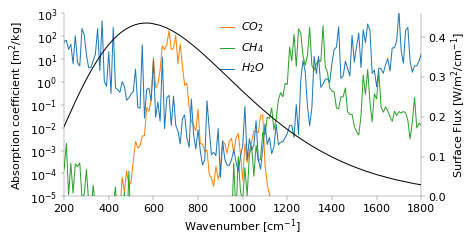

In [367]:
molecules_plot = ['co2', 'ch4', 'h2o']
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in molecules_plot:
    nu_use, absorb_coef_use = hitran.plot_absorption_coefficient(key, hitran.p_reference, temp_surf, do_plot=False)
    ax.plot(nu_use, absorb_coef_use, color=colors_molecule[key], label=label_molecule[key])
ax.set_xlim(ax_lim_spectrum)
ax.set_yscale('log')
ax.yaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_locator(plt.NullLocator())
# ax.set_yticks(None)
ax.set_ylim(10**-5, 10**3)
ax.set_xlabel('Wavenumber [cm$^{-1}$]')
ax.set_ylabel('Absorption coefficient [m$^2$/kg]')

ax2 = ax.twinx()
ax2.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='k')
ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel('Surface Flux [W/m$^2$/cm$^{-1}$]')
ax2.set_ylim(ax_lim_flux)


update_linewidth_use(fig)
if 'ch4' in molecules_plot:
    add_legend(ax)
update_fontsize_use(fig)
plt.show()
savefig(fig)

In [368]:
co2_conc = np.arange(0, 1000+50, 50)
co2_conc[0] = 1   # otherwise get 0 error
n_conc = co2_conc.size
olr_breakdown = {key2: {key: np.zeros((n_conc, n_bands)) for key in ['all', 'surface', 'atmos']} for key2 in ['co2', 'ch4', 'gray', 'h2o']}
pbar = tqdm(total=n_conc*3)
for key in ['co2', 'ch4', 'gray']:
    for i in range(n_conc):
        key_mass = 'co2' if key=='gray' else key
        atmos_use = RealGas(nz='auto', ny=1, molecule_names=[key], p_toa=p_toa,
                             q_funcs={key: humidity.constant_q}, q_funcs_args={key: (eqv_ppmv(key_mass, co2_conc[i]), key_mass)},
                             T_func=temp_profile_use, n_nu_bands=n_bands)
        olr_breakdown[key]['all'][i] = atmos_use.up_flux[0]
        var = atmos_use.get_flux(include_olr_breakdown=True)[2]
        olr_breakdown[key]['surface'][i] = var['surface']
        pbar.update(1)
    olr_breakdown[key]['atmos'] = olr_breakdown[key]['all'] - olr_breakdown[key]['surface']

  0%|          | 0/63 [00:00<?, ?it/s]

In [371]:
key = 'h2o'
for i in tqdm(range(n_conc)):
    key_mass = 'co2' if key=='gray' else key
    atmos_use = RealGas(nz='auto', ny=1, molecule_names=[key], p_toa=p_toa,
                         q_funcs={key: humidity.gradient_q}, q_funcs_args={key: (eqv_ppmv(key, co2_conc[i]), 0, h_tropopause*1000, key)},
                         T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown[key]['all'][i] = atmos_use.up_flux[0]
    var = atmos_use.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown[key]['surface'][i] = var['surface']
    pbar.update(1)
olr_breakdown[key]['atmos'] = olr_breakdown[key]['all'] - olr_breakdown[key]['surface']

  0%|          | 0/21 [00:00<?, ?it/s]

In [372]:
linestyle_olr = {'all': '-', 'surface': '--', 'atmos': ':'}
label_olr = {'all': 'Total', 'surface': 'Surface', 'atmos': 'Atmosphere'}
olr_area_tropopause = get_olr_area(atmos_base, flux=B_wavenumber(atmos_base.nu_bands['centre'], temp_tropopause) * np.pi)
olr_area_surface = get_olr_area(atmos_base, flux=B_wavenumber(atmos_base.nu_bands['centre'], temp_surf) * np.pi)

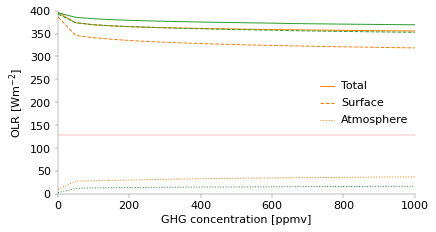

In [379]:
plot_diff = False
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key2 in ['co2', 'ch4']:
    # if not plot_diff and key2 == 'ch4':
    #     continue
    for key in olr_breakdown[key2]:
        var = [get_olr_area(atmos_base, flux=olr_breakdown[key2][key][i]) for i in range(n_conc)]
        if plot_diff and key != 'atmos':
            var -= olr_area_surface
        ax.plot(co2_conc, var, color=colors_molecule[key2], linestyle=linestyle_olr[key], label=label_olr[key] if key2 == 'co2' else None)
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth_use(fig)
add_legend(ax)
update_fontsize_use(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_xlim(0, co2_conc[-1])
if not plot_diff:
    ax.axhline(olr_tropopause, color='r', lw=ax_linewidth)
    ax.set_ylim(0, 400)
    ax.set_ylabel('OLR [Wm$^{-2}$]')
else:
    ax.set_ylabel('OLR change [Wm$^{-2}$]')
    ax.axhline(0, color='k', lw=ax_linewidth)
    ax.set_ylim(-100, 100)
plt.show()
savefig(fig)

In [380]:
dpi_gif = 800
fig, ax = plt.subplots(1, 1, dpi=dpi_gif)
fig_resize_use(fig)
fig.subplots_adjust(bottom=0.17)  # or top/left/right
update_fontsize_use(fig)

def animate(n, fig, key2):
    ax = fig.axes[0]
    for txt in ax.texts:
        txt.set_color('w')
    ax.clear()
    for key in olr_breakdown[key2]:
        ax.plot(atmos_base.nu_bands['centre'], olr_breakdown[key2][key][n], color='k', linestyle=linestyle_olr[key], label=label_olr[key])
    update_linewidth_use(fig)
    ax.plot(atmos_base.nu_bands['centre'], spectrum_surface, color='r', lw=ax_linewidth)
    ax.plot(atmos_base.nu_bands['centre'], spectrum_tropopause, color='r', lw=ax_linewidth)
    ax.set_xlim(ax_lim_spectrum)
    ax.set_ylim(ax_lim_flux)
    ax.set_xlabel('Wavenumber [cm$^{-1}$]')
    ax.set_ylabel('OLR spectrum [W/m$^2$/cm$^{-1}$]')
    add_legend(ax, loc='upper right')
    ax.set_title(f"{co2_conc[n]} ppmv")
    update_fontsize_use(fig)
    # print(n)

molecule_use = 'h2o'
anim = FuncAnimation(fig, animate, frames=n_conc, interval=150,
                     blit=False, repeat_delay=300, fargs=(fig, molecule_use))
plt.close()
HTML(anim.to_jshtml())

# Save animation
writervideo = matplotlib.animation.PillowWriter(fps=3)
anim.save(f'/Users/joshduffield/Desktop/{molecule_use}_spectra.mp4', writer='ffmpeg', fps=3)

### Combine All GHG in same world

In [415]:
q_funcs = {'CO2': humidity.constant_q, 'CH4': humidity.constant_q, 'H2O': humidity.constant_rh}
q_args = {'CO2': (370, 'CO2'), 'CH4': (1.75, 'CH4'), 'H2O': (temp_profile_use, 0.7, h_tropopause*1000, 'H2O')}

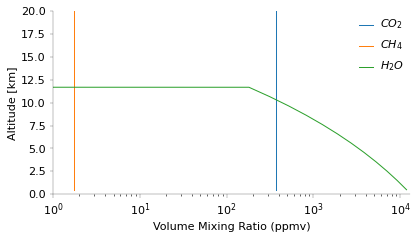

In [418]:
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in q_funcs:
    ax.plot(humidity.ppmv_from_humidity(
        q_funcs[key](atmos_base.p, *q_args[key]), key),
        p_altitude_convert(p=atmos_base.p)/1000, label=label_molecule[key.lower()])
ax.set_ylim(0, 20)
ax.set_xscale('log')
ax.set_xlabel('Volume Mixing Ratio (ppmv)')
ax.set_ylabel('Altitude [km]')
ax.set_xlim(1, 13000)
update_linewidth_use(fig)
add_legend(ax)
update_fontsize_use(fig)
plt.show()
savefig(fig)

In [419]:
 # OLR with just water, then add co2, then add methane

In [420]:
# Look at effect of adding mass eqv to 5ppmv of CO2 and methane, what is the total effect?